In [35]:
import os
import pandas as pd
import numpy as np
import joblib
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
#from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_recall_curve, auc, roc_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10,6)

os.environ["LOKY_MAX_CPU_COUNT"] = "4"  # Ajusta según tus cores lógicos

In [36]:
# =========================
# 0) Cargar modelos y preprocesadores
# =========================
models_path = r"C:/PROY_FINAL_ML/models/"

best_ridge = joblib.load(os.path.join(models_path, "best_ridge.pkl"))
best_hgb   = joblib.load(os.path.join(models_path, "best_hgb.pkl"))
best_hgb_clf = joblib.load(os.path.join(models_path, "best_hgb_clf.pkl"))

preproc_reg = joblib.load(os.path.join(models_path, "preproc_reg.pkl"))
preproc_clf = joblib.load(os.path.join(models_path, "preproc_clf.pkl"))

In [37]:
# =========================
# 1) Cargar datasets y features
# =========================
import joblib

# Cargar dataset original con columnas como producto, establecimiento, precio, etc.
df = pd.read_parquet("C:/PROY_FINAL_ML/data/processed/cba_clean.parquet")

# Cargamos conjuntos preprocesados
X_train = joblib.load("C:/PROY_FINAL_ML/data/processed/X_train.pkl")
X_valid = joblib.load("C:/PROY_FINAL_ML/data/processed/X_valid.pkl")
X_test  = joblib.load("C:/PROY_FINAL_ML/data/processed/X_test.pkl")

y_train = joblib.load("C:/PROY_FINAL_ML/data/processed/y_train.pkl")
y_valid = joblib.load("C:/PROY_FINAL_ML/data/processed/y_valid.pkl")
y_test  = joblib.load("C:/PROY_FINAL_ML/data/processed/y_test.pkl")

y_train_cls = joblib.load("C:/PROY_FINAL_ML/data/processed/y_train_cls.pkl")
y_valid_cls = joblib.load("C:/PROY_FINAL_ML/data/processed/y_valid_cls.pkl")
y_test_cls  = joblib.load("C:/PROY_FINAL_ML/data/processed/y_test_cls.pkl")

# Cargamos listas de features
num_feats = joblib.load("C:/PROY_FINAL_ML/data/processed/num_feats.pkl")
cat_feats = joblib.load("C:/PROY_FINAL_ML/data/processed/cat_feats.pkl")

print("✅ Datasets y listas de features cargados correctamente.")

✅ Datasets y listas de features cargados correctamente.


In [38]:
# =========================
# 2) Funciones métricas
# =========================
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

In [39]:
# =========================
# 3) Predicciones
# =========================
# Regresión
y_pred_ridge = best_ridge.predict(X_test)
y_pred_hgb   = best_hgb.predict(X_test)

# Clasificación
y_pred_clf   = best_hgb_clf.predict(X_test)
y_proba_clf  = best_hgb_clf.predict_proba(X_test)[:,1]

In [40]:
# =========================
# 4) Métricas
# =========================
metrics_reg = pd.DataFrame({
    "Model": ["Ridge", "HGBReg"],
    "RMSE": [rmse(y_test, y_pred_ridge), rmse(y_test, y_pred_hgb)],
    "MAE":  [mae(y_test, y_pred_ridge), mae(y_test, y_pred_hgb)],
    "R2":   [r2_score(y_test, y_pred_ridge), r2_score(y_test, y_pred_hgb)]
})

metrics_clf = pd.DataFrame({
    "Model": ["HGBCls"],
    "Accuracy": [accuracy_score(y_test_cls, y_pred_clf)],
    "F1-macro": [f1_score(y_test_cls, y_pred_clf, average="macro")],
    "ROC-AUC": [roc_auc_score(y_test_cls, y_proba_clf)]
})

print("=== Métricas Regresión ===")
print(metrics_reg)
print("\n=== Métricas Clasificación ===")
print(metrics_clf)

=== Métricas Regresión ===
    Model      RMSE       MAE        R2
0   Ridge  0.802967  0.334759  0.875169
1  HGBReg  0.737413  0.237161  0.894719

=== Métricas Clasificación ===
    Model  Accuracy  F1-macro   ROC-AUC
0  HGBCls  0.927846  0.670325  0.896816


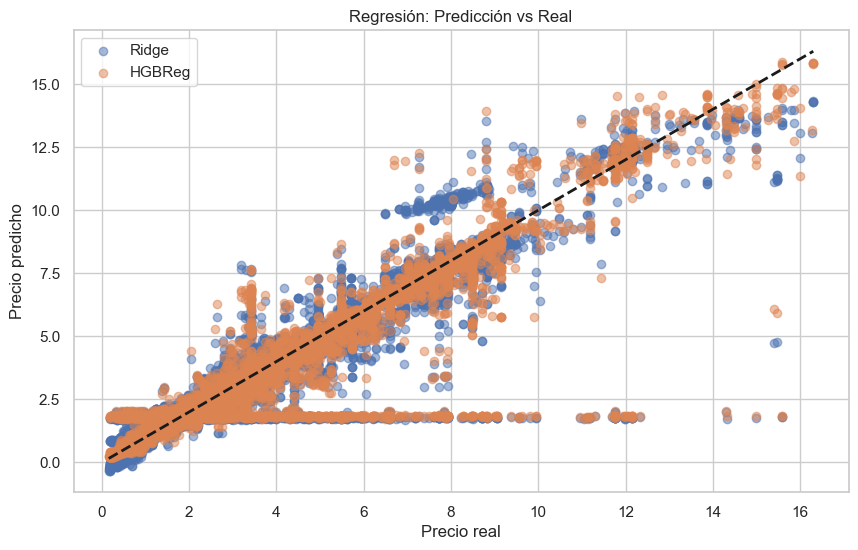

In [41]:
# =========================
# 5) Gráficas – Regresión
# =========================
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_ridge, alpha=0.5, label="Ridge")
plt.scatter(y_test, y_pred_hgb, alpha=0.5, label="HGBReg")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Precio real")
plt.ylabel("Precio predicho")
plt.title("Regresión: Predicción vs Real")
plt.legend()
plt.show()

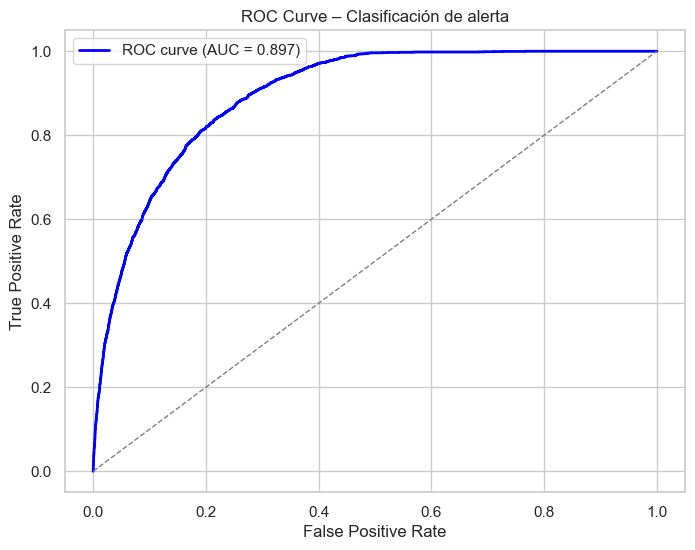

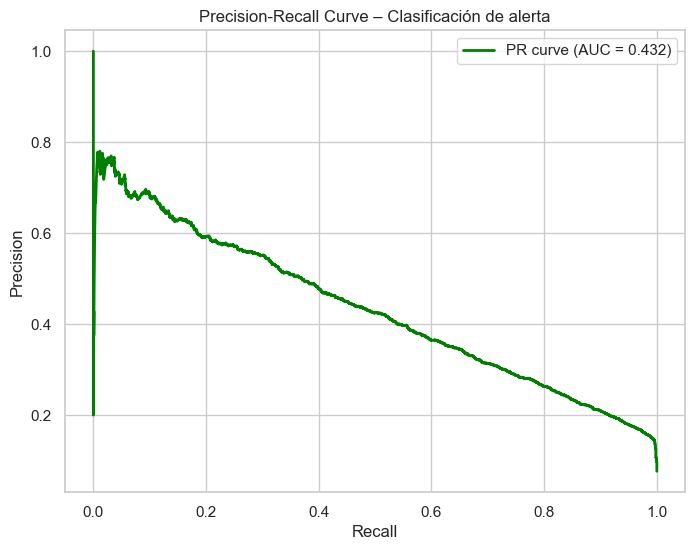

In [42]:
# =========================
# 6) Gráficas – Clasificación ROC y PR
# =========================
fpr, tpr, _ = roc_curve(y_test_cls, y_proba_clf)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Clasificación de alerta')
plt.legend()
plt.show()

precision, recall, _ = precision_recall_curve(y_test_cls, y_proba_clf)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, color='green', lw=2, label=f'PR curve (AUC = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve – Clasificación de alerta')
plt.legend()
plt.show()

100%|===================| 35487/35660 [01:56<00:00]        

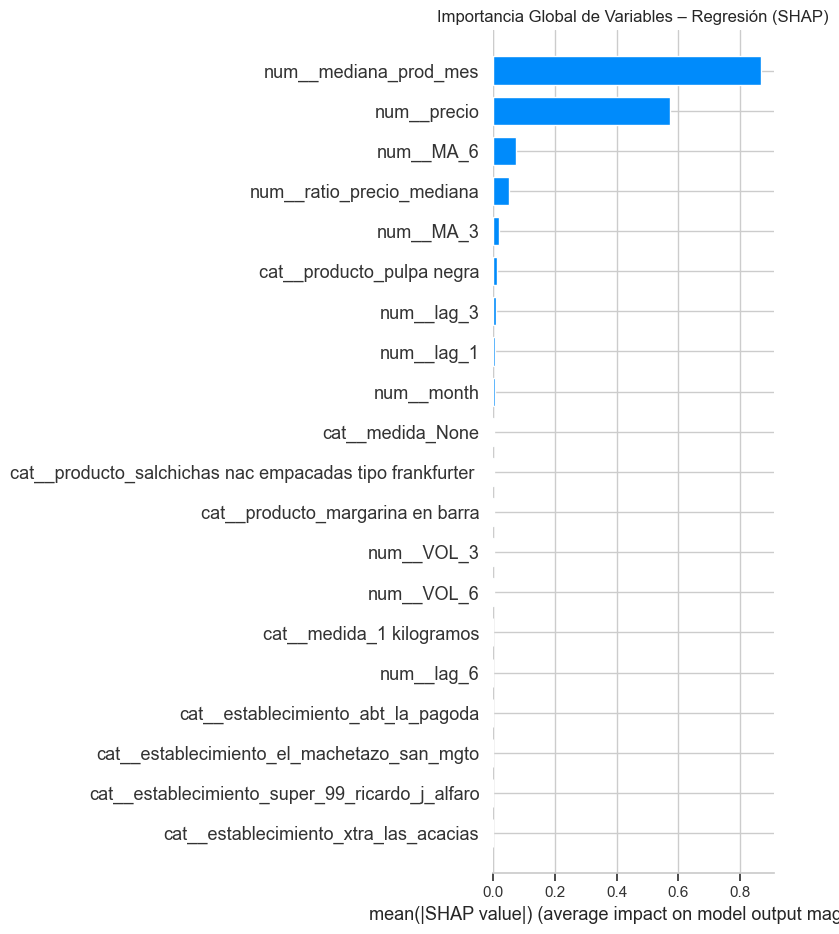

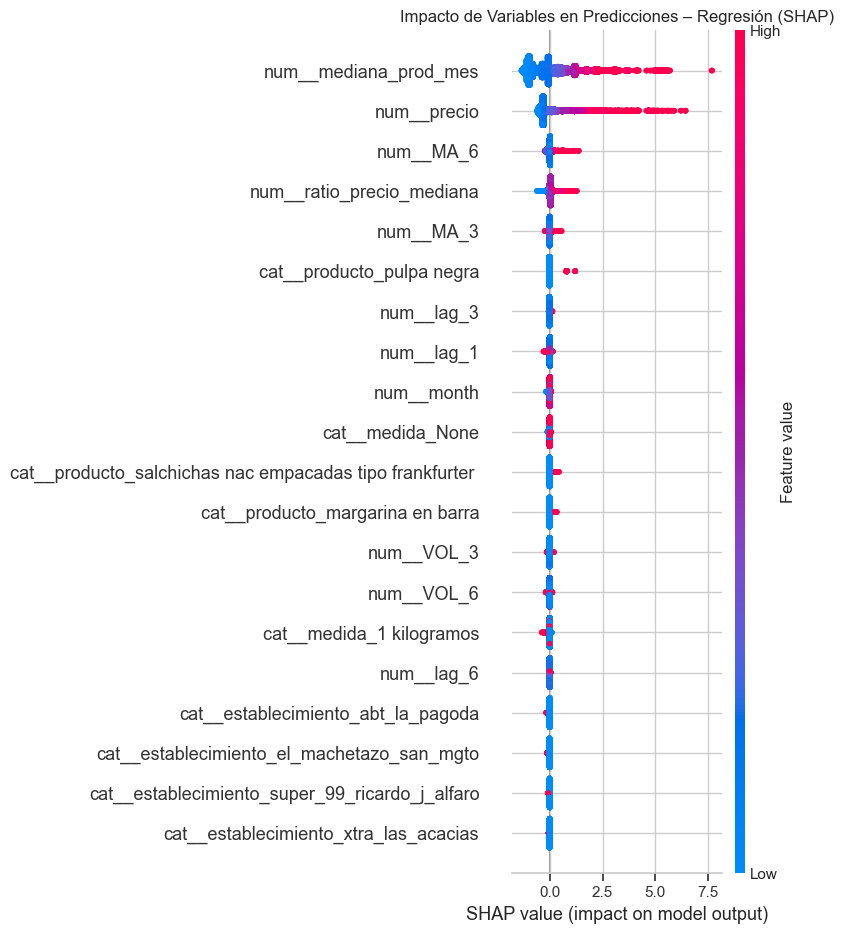

100%|===================| 35529/35660 [03:33<00:00]        

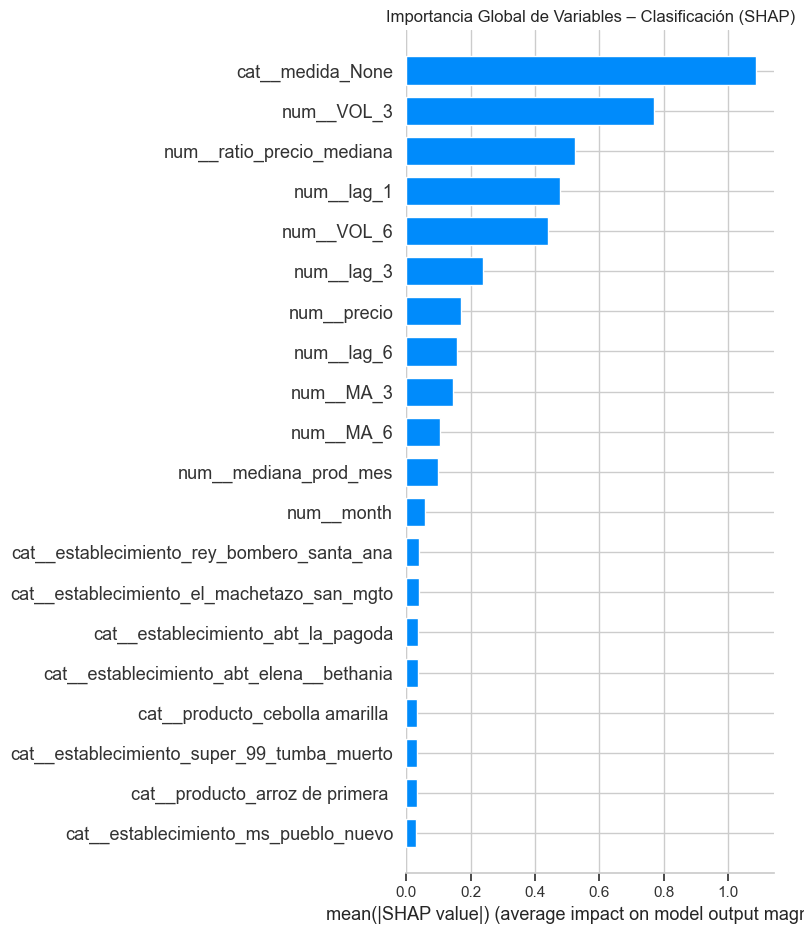

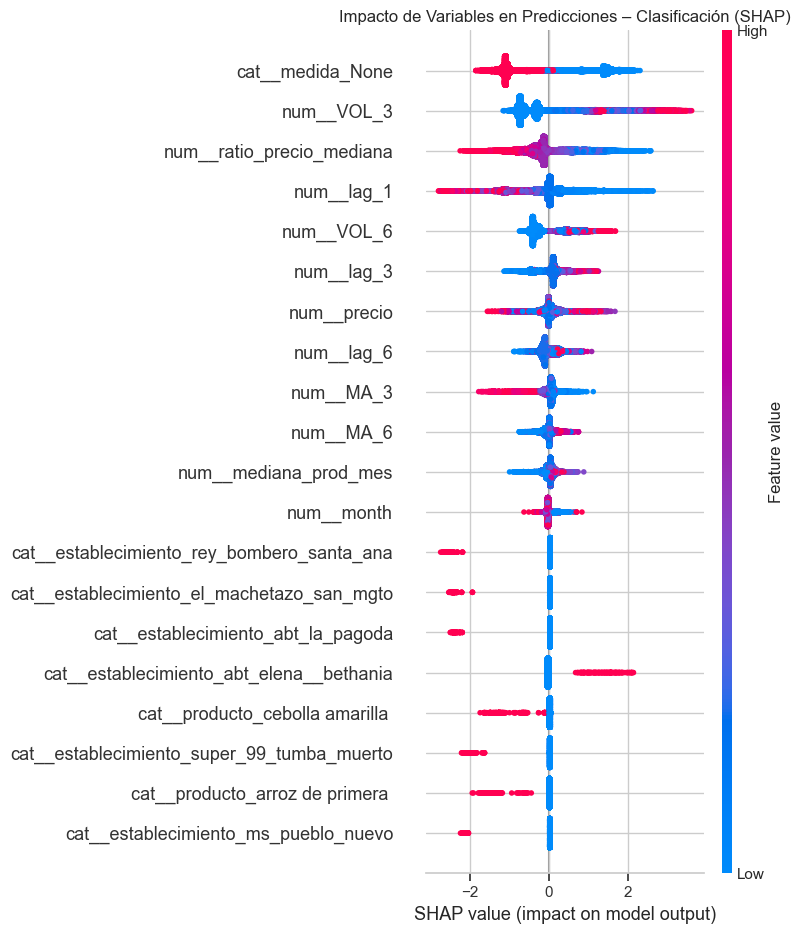

In [25]:
# =========================
# 7) SHAP – Explicabilidad
# =========================

import shap
import matplotlib.pyplot as plt

# -------------------------
# 📌 SHAP para Regresión (best_hgb)
# -------------------------
X_test_trans = preproc_reg.transform(X_test)

explainer_hgb = shap.Explainer(best_hgb["model"], X_test_trans)
shap_values_hgb = explainer_hgb(X_test_trans, check_additivity=False)

# Gráfico de barras
plt.title("Importancia Global de Variables – Regresión (SHAP)")
shap.summary_plot(
    shap_values_hgb,
    X_test_trans,
    feature_names=preproc_reg.get_feature_names_out(),
    plot_type="bar",
    show=True
)

# Gráfico beeswarm
plt.title("Impacto de Variables en Predicciones – Regresión (SHAP)")
shap.summary_plot(
    shap_values_hgb,
    X_test_trans,
    feature_names=preproc_reg.get_feature_names_out(),
    show=True
)


# -------------------------
# 📌 SHAP para Clasificación (best_hgb_clf)
# -------------------------
X_test_trans_cls = preproc_clf.transform(X_test)

explainer_hgb_cls = shap.Explainer(best_hgb_clf["model"], X_test_trans_cls)
shap_values_hgb_cls = explainer_hgb_cls(X_test_trans_cls, check_additivity=False)

# Gráfico de barras
plt.title("Importancia Global de Variables – Clasificación (SHAP)")
shap.summary_plot(
    shap_values_hgb_cls,
    X_test_trans_cls,
    feature_names=preproc_clf.get_feature_names_out(),
    plot_type="bar",
    show=True
)

# Gráfico beeswarm
plt.title("Impacto de Variables en Predicciones – Clasificación (SHAP)")
shap.summary_plot(
    shap_values_hgb_cls,
    X_test_trans_cls,
    feature_names=preproc_clf.get_feature_names_out(),
    show=True
)